# Non-Parametric Deep Learning Framework For Supply Chain Demand Forecasting
### Course: Deep Learning
### Lecturer: Dr Ramesh
### Name: Mehluli Nokwara

# Dataset source link:

https://drive.google.com/drive/folders/1cuAC2vqmgR-mVQoKIvjboxbM5f8YYCFE?usp=sharing

# Approach being used 

- Hierarchical time-series problem treated as 30,491 individual series (item-store level)
- Public validation period = d_1914–d_1941 (28 days after d_1913)
- Private period = d_1942–d_1969 — never touched until final retrain

### Two-phase training:
Phase 1: Train on sales_train_validation.csv (d_1–d_1913) → validate on d_1914–d_1941
Phase 2 (final only): Retrain everything on sales_train_evaluation.csv (d_1–d_1941) → predict d_1942–d_1969

### Feature Engineering Strategy
- Full long-format table (58M+ rows) built once with calendar + sell_price
- Global Prophet model on total Walmart sales - extract trend + yearly + weekly + holiday effects as features for every series
- Lag features: 7, 14, 21, 28, 35, 56, 90, 180 days
- Rolling statistics (shifted by 1): mean, std, max over 7/14/28/60 days
- Price momentum and price relative to item-store average
- SNAP flags, event flags, weekend flags, month/week features
- All lag/rolling NaNs filled with 0 (critical for sparse series

### Modeling Stack (final ensemble)
- LightGBM (60–70% weight) — recursive forecasting, global model on all 30k series, categorical features (item_id, store_id, etc.), RMSSE-aware validation
- LightGBM direct 28-step or quantile version (10–15%) — second diversity
- LSTM (10–15%) — only on the top 5,000–7,000 densest series (others stay LightGBM)
- Prophet components + tiny per-series Prophet on ~3,000 densest items (5–10%) — mainly for strong seasonal food items
- Final predictions = weighted average tuned on the true 28-day validation (d_1914–d_1941)

### Validation
- Always 28-day rolling origin: train up to day X → predict next 28 → measure WRMSSE

### 1. Uncomment to Install dependancies


In [1]:
#!pip install pandas numpy matplotlib seaborn scipy tqdm pyarrow

### 2. Library imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime
import matplotlib.dates as mdates
from cycler import cycler
from scipy import signal
from scipy.stats import jarque_bera as jb
import gc
import os
from tqdm.notebook import tqdm # To save files to avoid > 50 million rows in one go 

CHUNK_SIZE = 5_000_000          # Safe chunk size
OUTPUT_FILE = 'data/m5_base_features.feather'

# Make sure output directory exists
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the datasets
calendar_path = 'data/calendar.csv'
sell_prices_path = 'data/sell_prices.csv'
#sales_train_evaluation = 'data/sales_train_evaluation.csv'
sales_train_validation_csv = 'data/sales_train_validation.csv'

calendar = pd.read_csv(calendar_path)
sell_prices = pd.read_csv(sell_prices_path)

In [4]:
# description of calendar data
print("Calendar Data Descrption")
calendar.info()
calendar.head(3)

Calendar Data Descrption
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [5]:
# description of sell data
print("\nSell Prices Data Descrption")
sell_prices.info()
sell_prices.head(2)


Sell Prices Data Descrption
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


In [6]:
# Reduce memory usage for everything
def downcast_df(df):
  for col in df.columns:
    if df[col].dtype == 'int64':
      df[col] = pd.to_numeric(df[col], downcast='integer')
    elif df[col].dtype == 'float64':
      df[col] = pd.to_numeric(df[col], downcast='float')
  return df

calendar = downcast_df(calendar)
sell_prices = downcast_df(sell_prices)
sell_prices['sell_price'] = sell_prices['sell_price'].astype('float32')

# Create a price dictionary for memory efficiency - store_id + item_id + wm_yr_wk
price_dict = sell_prices.set_index(['store_id', 'item_id', 'wm_yr_wk'])['sell_price'].to_dict()

del sell_prices
gc.collect()

0

In [7]:
# Melt sales in chunks
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_cols = [f'd_{i}' for i in range(1, 1914)]  # d_1 to d_1913 (validation set)

sales_train = pd.read_csv(sales_train_validation_csv, usecols=id_cols + sales_cols)
sales_train = downcast_df(sales_train)

print(f"Starting chunked processing... total rows to write = 57.9M ")
first_chunk = True

for i in tqdm(range(0, len(sales_cols), 100), desc="Melting chunks"): # 100 days per chunk
  chunk_cols = sales_cols[i:i+100]
  temp = pd.melt(
      sales_train, 
      id_vars=id_cols, # columns that should not change
      value_vars=chunk_cols, # columns with values to unpivot
      var_name='d', # name for the column that will hold the original column headers from value_vars
      value_name='sales' # new name for the column that will hold the data values that were originally in the value_vars columns
  )
  
  # Merge calendar (tiny and safe) 
  temp = temp.merge(calendar[['d', 'date', 'wm_yr_wk', 'wday', 'month', 'year',
                               'event_name_1', 'snap_CA', 'snap_TX', 'snap_WI']], 
                    on='d', how='left'
                   )
  
  # Convert date, d_int, sales 
  temp['date'] = pd.to_datetime(temp['date'])
  temp['d_int'] = temp['d'].str[2:].astype('int16')
  temp['sales'] = temp['sales'].astype('float32')

  # Add sell_price safely using dict
  temp['sell_price'] = temp.set_index(['store_id', 'item_id', 'wm_yr_wk']).index.map(price_dict)
  temp['sell_price'] = temp.groupby('id')['sell_price'].transform(lambda x: x.ffill().bfill())
  temp['sell_price'] = temp['sell_price'].astype('float32')

  # Basic features
  temp['month'] = temp['date'].dt.month.astype('int8')
  temp['wday'] = temp['wday'].astype('int8')  # 1=Sat, 7=Fri
  temp['is_weekend'] = np.where(temp['wday'] <= 2, 1, 0).astype('int8')  # Sat=1, Sun=2
  temp['snap'] = temp[['snap_CA', 'snap_TX', 'snap_WI']].max(axis=1).astype('int8')
  temp['has_event'] = temp['event_name_1'].notna().astype('int8')

  # Drop unused
  temp = temp.drop(columns=['event_name_1'], errors='ignore')

  # Save chunk using append method for fast method
  if first_chunk:
    temp.to_feather(OUTPUT_FILE)
    first_chunk = False
  else:
    # Faster than concat + rewrite previously used
    temp.to_feather('data/_temp_chunk.feather')
    # Use pyarrow to append
    import pyarrow.feather as pqf # for data efficient representation of data
    import pyarrow as pa # for data efficient operations
    table1 = pqf.read_table(OUTPUT_FILE)
    table2 = pqf.read_table('data/_temp_chunk.feather')
    pqf.write_feather(pa.concat_tables([table1, table2]), OUTPUT_FILE)
    # Cleanup of pyarrow objects and temp file
    del table1, table2
    os.remove('data/_temp_chunk.feather')

  # Clean up
  del temp
  gc.collect()

print(f"Base features saved to {OUTPUT_FILE}")

Starting chunked processing... total rows to write = 57.9M 


Melting chunks:   0%|          | 0/20 [00:00<?, ?it/s]

Base features saved to data/m5_base_features.feather


In [8]:
# Loading the recently created dataset
df = pd.read_feather('data/m5_base_features.feather')
print(df.shape)

(58327370, 21)


In [9]:
df.tail(3)
# data is showing: sales(d_1 - d1913), calendar + events + SNAP, sell_price (weekly), date features

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,snap_CA,snap_TX,snap_WI,d_int,sell_price,is_weekend,snap,has_event
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0.0,2016-04-24,11613,...,4,2016,0,0,0,1913,3.98,1,0,0
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3.0,2016-04-24,11613,...,4,2016,0,0,0,1913,1.28,1,0,0
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1913,0.0,2016-04-24,11613,...,4,2016,0,0,0,1913,1.00,1,0,0


### 2. Feature Engineering
- Implementing a Global Prophet to identify trends that are not noisy, i.e., seasonality, and trend
- The strategy for the global prophet is to train the model per daily sales per category
- Add Lag or rolling features for mean, std deviation, and momentum to have a feature-rich solution
- Rolling and Lag features were added on a global level with chunking for the sake of memory efficiency

In [10]:
#!pip install prophet
from prophet import Prophet

FINAL_FILE = 'data/m5_features_v1.feather'
os.makedirs('data', exist_ok=True)

# Sorting data by id and date
df.sort_values(['id', 'date']).reset_index(drop=True)

Importing plotly failed. Interactive plots will not work.


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,snap_CA,snap_TX,snap_WI,d_int,sell_price,is_weekend,snap,has_event
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,2011-01-29,11101,...,1,2011,0,0,0,1,2.00,1,0,0
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,2011-01-30,11101,...,1,2011,0,0,0,2,2.00,1,0,0
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,2011-01-31,11101,...,1,2011,0,0,0,3,2.00,0,0,0
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,2011-02-01,11101,...,2,2011,1,1,0,4,2.00,0,1,0
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,2011-02-02,11101,...,2,2011,1,0,1,5,2.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1909,0.0,2016-04-20,11612,...,4,2016,0,0,0,1909,5.94,0,0,0
58327366,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1910,0.0,2016-04-21,11612,...,4,2016,0,0,0,1910,5.94,0,0,0
58327367,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1911,0.0,2016-04-22,11612,...,4,2016,0,0,0,1911,5.94,0,0,0
58327368,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1912,0.0,2016-04-23,11613,...,4,2016,0,0,0,1912,5.94,1,0,0


### 3. Train global prophet and use its output add rich features

In [11]:
# Category-level Prophet Modeling
print("Training Prophet models per Category...")

# 1. Aggregate sales by Date AND Category
cat_sales = df.groupby(['date', 'cat_id'])['sales'].sum().reset_index()
cat_sales = cat_sales.rename(columns={'date': 'ds', 'sales': 'y'})

# 2. Define Holidays (Same configuration as before)
superbowl = pd.DataFrame({
    'holiday': 'SuperBowl',
    'ds': pd.to_datetime(['2011-02-06','2012-02-05','2013-02-03','2014-02-02','2015-02-01','2016-02-07']),
    'lower_window': -3, 'upper_window': 1
})

blackfriday = pd.DataFrame({
    'holiday': 'BlackFriday',
    'ds': pd.to_datetime(['2011-11-25','2012-11-23','2013-11-29','2014-11-28','2015-11-27']),
    'lower_window': 0, 'upper_window': 3
})
holidays_df = pd.concat([superbowl, blackfriday])

# 3. Iterate through categories and train separate models
categories = cat_sales['cat_id'].unique()
forecasts_list = []

for cat in categories:
    print(f"Fitting Prophet for category: {cat}")
    
    # Filter data for specific category
    group_data = cat_sales[cat_sales['cat_id'] == cat].copy()

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',
        holidays_prior_scale=10
    )
    
    m.add_country_holidays(country_name='US') 
    m.holidays = holidays_df

    m.fit(group_data)

    # Predict
    future = m.make_future_dataframe(periods=56)
    forecast = m.predict(future)

    # Extract relevant columns and add linking key
    forecast = forecast[['ds', 'trend', 'yearly', 'weekly', 'holidays']]
    forecast['cat_id'] = cat # Critical for merging back to specific items

    forecasts_list.append(forecast)

# 4. Combine all forecasts into one dataframe
all_forecasts = pd.concat(forecasts_list)

# 5. Merge components back to main dataframe using Date AND Cat_ID
# We keep the column names 'global_...' so the downstream LightGBM code doesn't break,
# but these now represent "Category-Specific" trends.
df = df.merge(all_forecasts, 
              left_on=['date', 'cat_id'], 
              right_on=['ds', 'cat_id'], 
              how='left'
)

df.drop('ds', axis=1, inplace=True)
df.rename(columns={
    'trend': 'global_trend',
    'yearly': 'global_yearly',
    'weekly': 'global_weekly',
    'holidays': 'global_holiday'
}, inplace=True)

print("Category-specific Prophet components added")

Training Prophet models per Category...
Fitting Prophet for category: FOODS


17:11:46 - cmdstanpy - INFO - Chain [1] start processing
17:11:46 - cmdstanpy - INFO - Chain [1] done processing
17:11:46 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet for category: HOBBIES


17:11:46 - cmdstanpy - INFO - Chain [1] done processing
17:11:47 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet for category: HOUSEHOLD


17:11:47 - cmdstanpy - INFO - Chain [1] done processing


Category-specific Prophet components added


In [12]:
# LAG/ROLLING CHUNK
print("Adding lag & rolling features in chunks...")

import pyarrow.feather as pqf
import pyarrow as pa
import os
import gc
from tqdm.notebook import tqdm

LAGS = [7, 14, 21, 28, 35, 56, 90, 180] # How did sales for the item happen in the last Monday?
ROLL_WINDOWS = [7, 14, 28, 60] # What is the average performance over the past # of days?

unique_ids = df['id'].unique()
chunk_size = 2000
first = True

for start in tqdm(range(0, len(unique_ids), chunk_size), desc="Lag/Rolling chunks"):
    ids_chunk = unique_ids[start:start + chunk_size]
    temp = df[df['id'].isin(ids_chunk)].copy()
    temp = temp.sort_values(['id', 'date']).reset_index(drop=True)

    # Lags 
    for lag in LAGS:
        temp[f'lag_{lag}'] = temp.groupby('id')['sales'].shift(lag)

    # Rolling stats (no leakage)
    for w in ROLL_WINDOWS:
        temp[f'roll_mean_{w}'] = temp.groupby('id')['sales'].shift(1).transform(
            lambda s: s.rolling(w, min_periods=1).mean())
        temp[f'roll_std_{w}']  = temp.groupby('id')['sales'].shift(1).transform(
            lambda s: s.rolling(w, min_periods=1).std())
        temp[f'roll_max_{w}']  = temp.groupby('id')['sales'].shift(1).transform(
            lambda s: s.rolling(w, min_periods=1).max())

    # Price momentum 
    temp['price_mom'] = temp['sell_price'] / temp.groupby('id')['sell_price'].shift(1)
    temp['price_mom'] = temp['price_mom'].replace([np.inf, -np.inf], np.nan).fillna(1.0)

    # Fill NaNs
    new_features = [c for c in temp.columns 
                    if any(c.startswith(p) for p in ['lag_', 'roll_', 'price_', 'global_'])]
    temp[new_features] = temp[new_features].fillna(0).astype('float32')

    # Drop unused 
    temp = temp.drop(columns=['d', 'wm_yr_wk'], errors='ignore')

    # SAVE CHUNK
    if first:
        temp.to_feather('data/m5_features_v1.feather')
        first = False
    else:
        # Append safely
        temp.to_feather('data/_tmp.feather')
        existing_table = pqf.read_table('data/m5_features_v1.feather')
        new_table      = pqf.read_table('data/_tmp.feather')
        pqf.write_feather(pa.concat_tables([existing_table, new_table]), 
                          'data/m5_features_v1.feather')
        os.remove('data/_tmp.feather')
        # Clean up only what exists
        del existing_table, new_table

    # Always delete temp

Adding lag & rolling features in chunks...


Lag/Rolling chunks:   0%|          | 0/16 [00:00<?, ?it/s]

### 4. LightGBM Model Training

In [13]:
#!pip install lightgbm
import lightgbm as lgb

print("loading the feature rich dataset for training...")
df = pd.read_feather('data/m5_features_v1.feather')

# Train on days 1885 
# Validate on days 1886 to 1913 (the last 28 days available) 
VAL_CUTOFF = 1885
train_mask = df['d_int'] <= VAL_CUTOFF
val_mask = (df['d_int'] > VAL_CUTOFF) & (df['d_int'] <= 1913)

# removing none-feature columns 
ignore_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 
               'sales', 'date', 'd', 'd_int', 'wm_yr_wk'] 
features = [col for col in df.columns if col not in ignore_cols]

print(f"Training with {len(features)} features: {features}")

# Create LightGBM datasets
train_data = lgb.Dataset(
    df[train_mask][features],
    label=df[train_mask]['sales'],
    free_raw_data=False # Keeping data in memory for faster iterations
)

val_data = lgb.Dataset(
    df[val_mask][features],
    label=df[val_mask]['sales'],
    reference=train_data,
    free_raw_data=False
)

# Clean dataset to free RAM
del df
gc.collect()



loading the feature rich dataset for training...
Training with 35 features: ['wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'is_weekend', 'snap', 'has_event', 'global_trend', 'global_yearly', 'global_weekly', 'global_holiday', 'lag_7', 'lag_14', 'lag_21', 'lag_28', 'lag_35', 'lag_56', 'lag_90', 'lag_180', 'roll_mean_7', 'roll_std_7', 'roll_max_7', 'roll_mean_14', 'roll_std_14', 'roll_max_14', 'roll_mean_28', 'roll_std_28', 'roll_max_28', 'roll_mean_60', 'roll_std_60', 'roll_max_60', 'price_mom']


120

In [14]:
# Hyperparameter tunied for M5 dataset
params = {
    'objective': 'tweedie',     # Best for sales with many zeros
    'tweedie_variance_power': 1.1, 
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 128,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.8,    # Select 80% of features per tree (prevents overfitting)
    'bagging_fraction': 0.7,    # Select 70% of rows per tree
    'bagging_freq': 1,
    'seed': 42,
    'verbosity': -1,
    'n_jobs': -1                # Use all CPU cores
}

print("starting training...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=1500,       # Max trees
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50), # Stop if no improvement for 50 rounds
        lgb.log_evaluation(100)
    ] 
)

# Save the model
model.save_model('m5_lgbm_model.txt')
print("Model saved to 'm5_lgbm_model.txt'")

starting training...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.63894	valid's rmse: 2.40525
[200]	train's rmse: 2.19077	valid's rmse: 2.01291
[300]	train's rmse: 2.0998	valid's rmse: 1.94734
[400]	train's rmse: 2.0757	valid's rmse: 1.93638
[500]	train's rmse: 2.06304	valid's rmse: 1.93338
[600]	train's rmse: 2.05225	valid's rmse: 1.93164
[700]	train's rmse: 2.04227	valid's rmse: 1.93074
Early stopping, best iteration is:
[704]	train's rmse: 2.04186	valid's rmse: 1.93065
Model saved to 'm5_lgbm_model.txt'


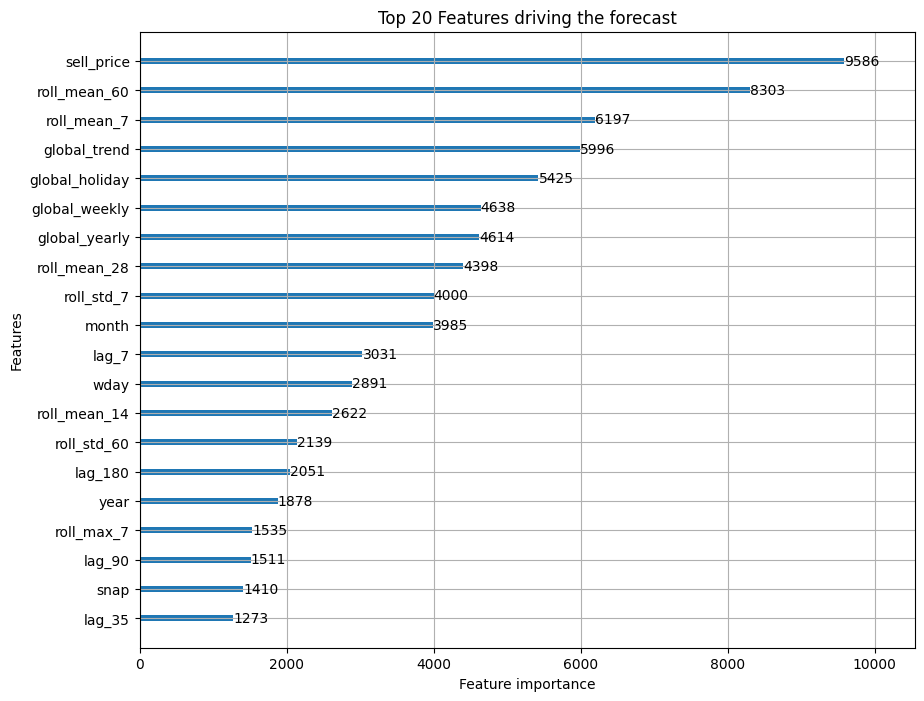

In [15]:
# Plot feature importance
lgb.plot_importance(model, max_num_features=20, figsize=(10, 8))
plt.title("Top 20 Features driving the forecast")
plt.show()

In [16]:
# first reloading the dataframe for predictions
df = pd.read_feather('data/m5_features_v1.feather')

# Re-define the validation mask
VAL_CUTOFF = 1885
val_mask = (df['d_int'] > VAL_CUTOFF) & (df['d_int'] <= 1913)

# Define features again to be safe
ignore_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 
               'sales', 'date', 'd', 'd_int', 'wm_yr_wk']
features = [col for col in df.columns if col not in ignore_cols]

# Generate predictions and sanity check
print("Predicting on validation set d_1886 to d_1913 ...")

# Use model to predict the validation rows
pred_eval = model.predict(df[val_mask][features])

# Add predictions back to the dataframe for plotting
df.loc[val_mask, 'pred_sales'] = pred_eval

Predicting on validation set d_1886 to d_1913 ...


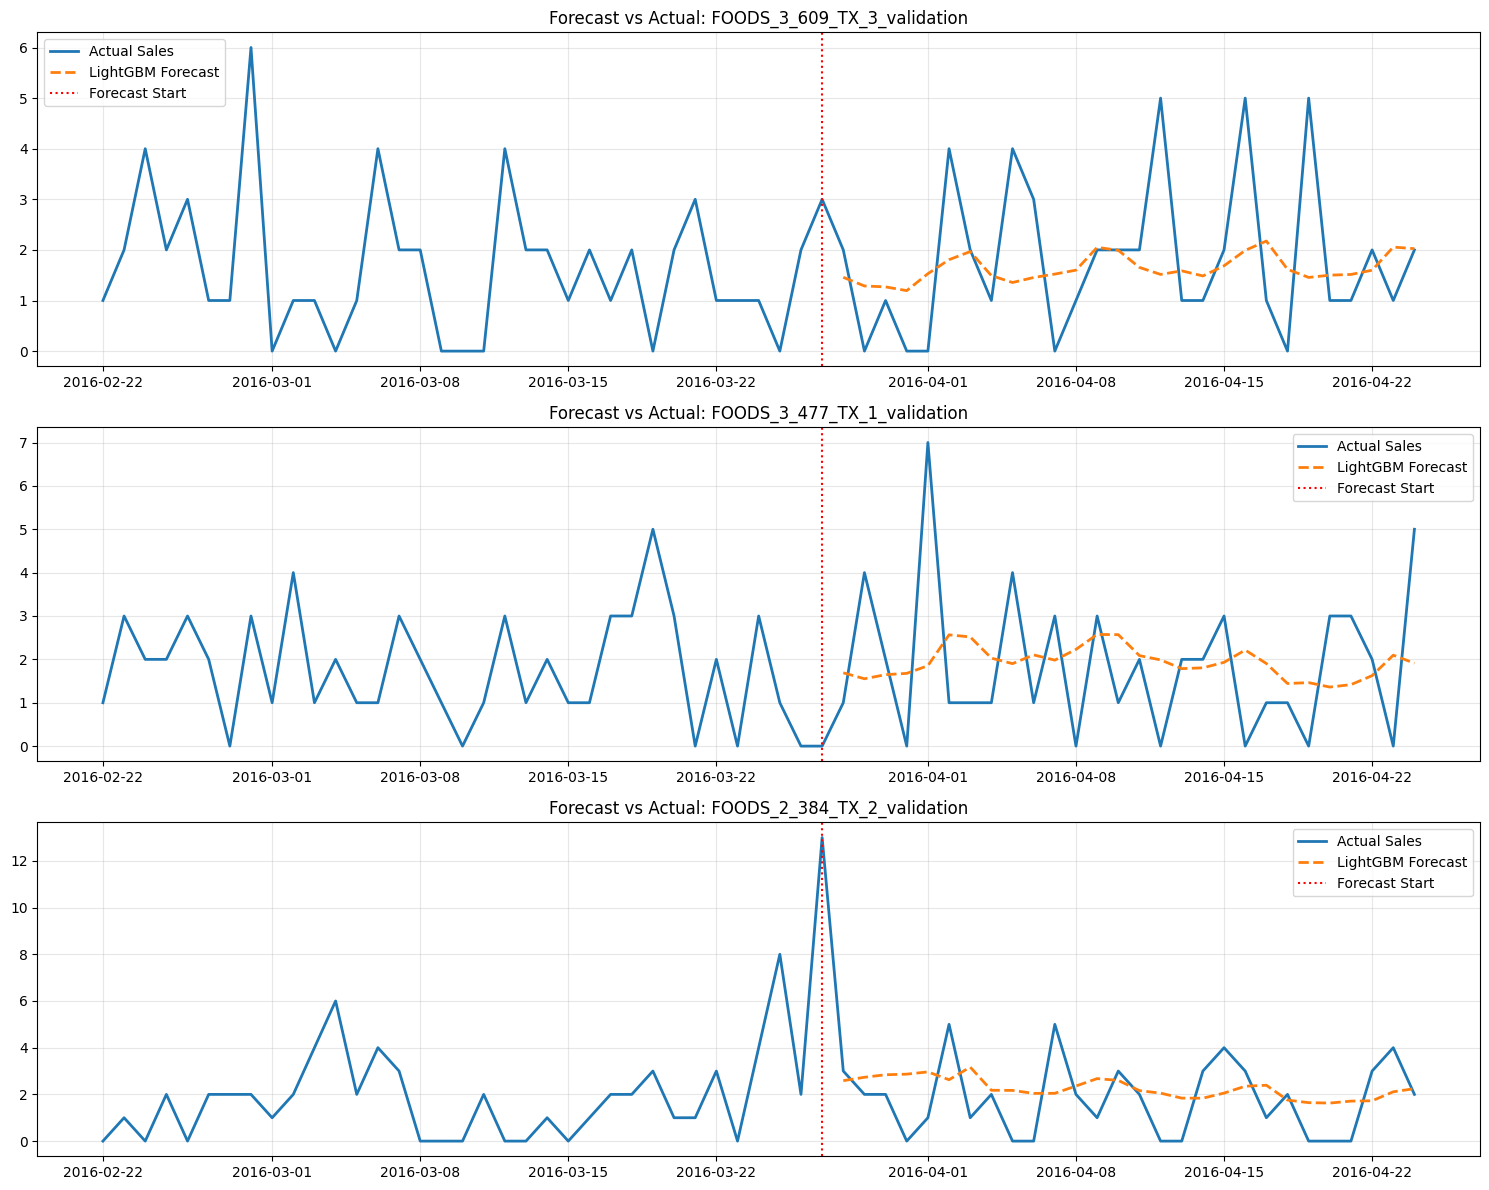

In [17]:
# Visualization test
import random
import matplotlib.pyplot as plt

# Pick 3 random items with high volume sales for visualization
high_vol_items = df[df['sales'] > 10]['id'].unique()
sample_ids = random.sample(list(high_vol_items), 3)

plt.figure(figsize=(15, 12))

for i, item_id in enumerate(sample_ids):
    plt.subplot(3, 1, i + 1)
    
    # Grab data for this item (Last 90 days only for clarity)
    item_data = df[(df['id'] == item_id) & (df['d_int'] > 1850)].copy()
    
    # Plot Actual Sales (Blue)
    plt.plot(item_data['date'], item_data['sales'], label='Actual Sales', color='tab:blue', linewidth=2)
    
    # Plot Predictions (Orange) - Only exists for d_1886+
    plt.plot(item_data['date'], item_data['pred_sales'], label='LightGBM Forecast', color='tab:orange', linestyle='--', linewidth=2)
    
    # Add a line showing where the forecast starts
    plt.axvline(pd.to_datetime('2016-03-27'), color='red', linestyle=':', label='Forecast Start')
    
    plt.title(f"Forecast vs Actual: {item_id}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
# Save predictions for Ensamble
# The format must be "d_" + number
df['d'] = 'd_' + df['d_int'].astype(str)

# Only id, day and predicted sales required
submission_lgbm = df.loc[val_mask, ['id', 'd', 'pred_sales']]

# Pivot to wide format as required in M5
submission_lgbm = submission_lgbm.pivot(index='id', columns='d', values='pred_sales').reset_index()

# Save to CSV
submission_lgbm.to_csv('lgbm_predictions.csv', index=False)
print("LightGBM predictions saved to lgbm_predictions.csv")
print("Ready for LSTM")

LightGBM predictions saved to lgbm_predictions.csv
Ready for LSTM


In [19]:
# cleaning to free RAM for LSTM
del df, submission_lgbm
import gc
gc.collect()

print("Ready for next model (LSTM).")

Ready for next model (LSTM).


### 5. Create the LSTM model
- Since the LSTM is computationally heavy the strategy restricts to top 1000 densest series
- This is because these will be items being sold daily and hence the model will be  better able to forecast as compared to sparse information

In [20]:
# transform data from 2D to 3D for LSTM 
from sklearn.preprocessing import MinMaxScaler

# load data and filter for dense items
print("Loading data for LSTM...")
df = pd.read_feather('data/m5_features_v1.feather')

#Calculating the sparsity or percentage of zeros
print("Finding the densest items...")
zeros = df.groupby('id')['sales'].apply(lambda x: (x == 0).sum()/len(x))

# specific strategy top 1000 dense items (low zero %)
dense_ids = zeros.sort_values().head(1000).index.tolist()

print(f"Selected {len(dense_ids)} dense items for LSTM.")
lstm_df = df[df['id'].isin(dense_ids)].copy()

del df, zeros # to manage the RAM memory
gc.collect() 

# Pivot to Wide Format (Dates x Items)
# We focus on SALES and PRICE for the LSTM to keep dimensions manageable
sales_pivot = lstm_df.pivot(index='d_int', columns='id', values='sales').fillna(0)
price_pivot = lstm_df.pivot(index='d_int', columns='id', values='sell_price').fillna(0)

# Normalization for Neural Networks
# LSTMs struggle if numbers are not between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
sales_scaled = scaler.fit_transform(sales_pivot)

# Usse Sales only as the primary feature to simplify the 3D tensor construction
print("Data shape:", sales_scaled.shape)

# Create Sequences (Sliding Window)
# X: Past 14 days
# Y: Next 1 day
def create_sequences(data, lookback=14):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i]) # The sequence (e.g., Days 1-14)
        y.append(data[i])            # The target (e.g., Day 15)
    return np.array(X), np.array(y)

LOOKBACK = 14
# Use data up to validation cutoff (1885)
train_data = sales_scaled[:1885] 
X_train, y_train = create_sequences(train_data, lookback=LOOKBACK)

X_train = np.transpose(X_train, (0, 2, 1)) # (Samples, Items, Timesteps)
X_train = X_train.reshape(-1, LOOKBACK, 1) # Stack items into one massive column
y_train = y_train.flatten()                # Stack targets

print(f"LSTM Input Shape: {X_train.shape}")

Loading data for LSTM...
Finding the densest items...
Selected 1000 dense items for LSTM.
Data shape: (1913, 1000)
LSTM Input Shape: (1871000, 14, 1)


In [21]:
#!pip install "numpy<2.0" tensorflow==2.16.1

In [22]:
# LSTM Model Training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define Model
model_lstm = Sequential([
    # Input shape: (14 days, 1 feature)
    LSTM(64, input_shape=(LOOKBACK, 1), return_sequences=True), 
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1) # Predict normalized sales
])

model_lstm.compile(optimizer='adam', loss='mse')

print("Starting LSTM training...")
# Use a subset for validation to monitor convergence
history = model_lstm.fit(
    X_train, y_train,
    epochs=5,             # Keep low for demonstration
    batch_size=2048,      # Large batch size for speed
    validation_split=0.1,
    verbose=1
)

model_lstm.save('m5_lstm_model.h5')
print("LSTM Model saved.")

Starting LSTM training...
Epoch 1/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 59s 70ms/step - loss: 0.0169 - val_loss: 0.0138
Epoch 2/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 0.0153 - val_loss: 0.0136
Epoch 3/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - loss: 0.0149 - val_loss: 0.0136
Epoch 4/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 0.0149 - val_loss: 0.0135
Epoch 5/5
823/823 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - loss: 0.0148 - val_loss: 0.0134


LSTM Model saved.


## 6. Ensemble Model

In [23]:
# Generate LSTM Predictions (Validation Set: d_1886 - d_1913)  
print("Generating LSTM predictions for validation set...")

# Preparing validation and prediction sequences
# predict d_1886 to d_1913
# To predict d_1886, need the 14 days prior (d_1872 - d_1885)
# To predict d_1913, need the 14 days prior (d_1899 - d_1912)
VAL_START = 1886
VAL_END = 1913
LOOKBACK = 14

# Slice the data: to have 14 days prior to start, up to the end
val_input_data = sales_scaled[VAL_START - LOOKBACK : VAL_END]
X_val = []

# Need to slide the window 28 times (once for each validation day)
for i in range(LOOKBACK, len(val_input_data) + 1): # +1 to include the last day
    # Example: First iter i=14. Slice [0:14] -> Days 1872-1885. Target is 1886.
    seq = val_input_data[i-LOOKBACK:i]
    X_val.append(seq)

X_val = np.array(X_val)

# Let's Transpose first -> (28 days, 1000 items, 14 lookback)
X_val_transposed = np.transpose(X_val, (0, 2, 1))

# Reshape -> (28 * 1000, 14, 1)
X_val_final = X_val_transposed.reshape(-1, LOOKBACK, 1)

print(f"Prediction input shape: {X_val_final.shape}")

print("Predicting...")
val_preds_scaled = model_lstm.predict(X_val_final, verbose=1)

# The predictions come out as (28000, 1) -> reshape to (28, 1000)
val_preds_reshaped = val_preds_scaled.reshape(28, -1) # 28 rows (days), 1000 cols (items)

# Inverse transform to get Real Sales
# Warning: scaler expects (n_samples, 1000), so we feed it (28, 1000) directly
val_preds_real = scaler.inverse_transform(val_preds_reshaped)

Generating LSTM predictions for validation set...
Prediction input shape: (28000, 14, 1)
Predicting...
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [24]:
# Format for Ensemble
# Transpose so rows are items (1000), cols are days (28)
val_preds_real = val_preds_real.T

submission_lstm = pd.DataFrame(val_preds_real, columns=[f'd_{i}' for i in range(VAL_START, VAL_END + 1)])
submission_lstm.insert(0, 'id', dense_ids) # dense_ids must be from Step 7

# Save
submission_lstm.to_csv('lstm_predictions.csv', index=False)
print("LSTM predictions saved to 'lstm_predictions.csv'")

LSTM predictions saved to 'lstm_predictions.csv'


Loading LSTM predictions...
Loading LightGBM predictions...
Loading Ground Truth (Actual Sales)...
Merging models...

FINAL SCHOOL REPORT METRICS
Baseline (LightGBM) RMSE:  1.9307
Ensemble (Hybrid)   RMSE:  1.9327
----------------------------------------
Improvement: -0.00200
NOTE: Ensemble did not improve. Try adjusting weights (e.g. 0.9/0.1)


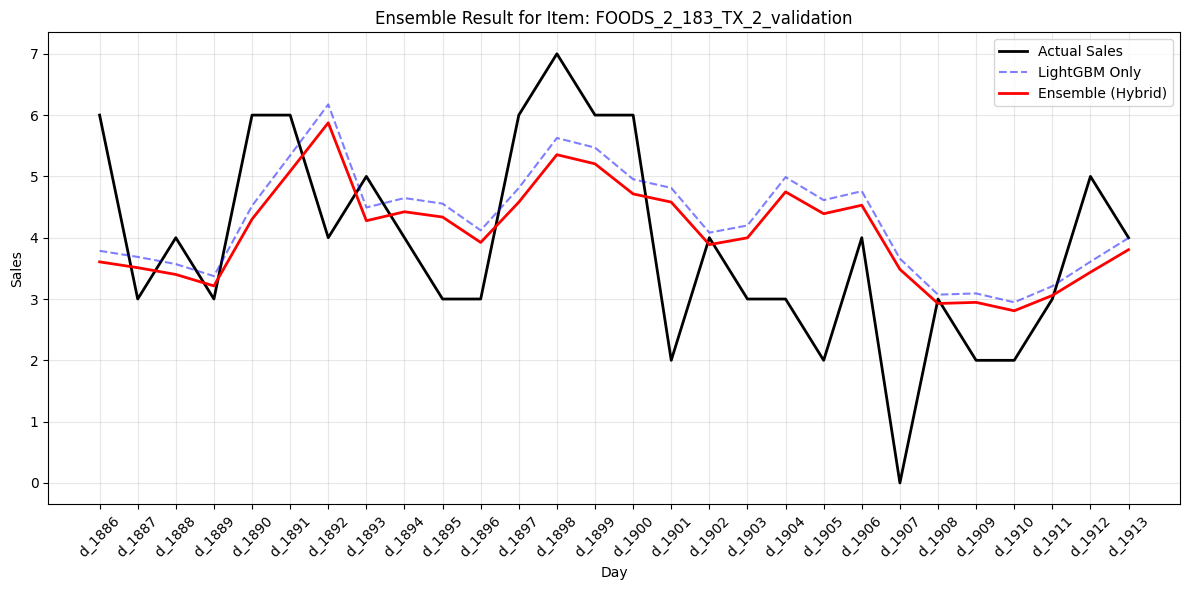

In [26]:
# 10. Ensemble and Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load LSTM Predictions
print("Loading LSTM predictions...")
lstm_preds = pd.read_csv('lstm_predictions.csv')
lstm_melt = lstm_preds.melt(id_vars=['id'], var_name='d', value_name='lstm_pred')

# Load LightGBM Predictions
print("Loading LightGBM predictions...")
lgbm_preds = pd.read_csv('lgbm_predictions.csv')
lgbm_melt = lgbm_preds.melt(id_vars=['id'], var_name='d', value_name='lgbm_pred')

# Load Ground Truth (Actual Sales)
print("Loading Ground Truth (Actual Sales)...")
df = pd.read_feather('data/m5_features_v1.feather')

# FIX: Recreate the 'd' column so we can merge
df['d'] = 'd_' + df['d_int'].astype(str)

# Filter for the validation period only
val_mask = (df['d_int'] > 1885) & (df['d_int'] <= 1913)
truth = df.loc[val_mask, ['id', 'd', 'sales']].copy()
truth.rename(columns={'sales': 'actual'}, inplace=True)

# Clean up big dataframe to save RAM
del df
import gc
gc.collect()

# Merge Everything
print("Merging models...")
# Start with Truth
ensemble = truth.merge(lgbm_melt, on=['id', 'd'], how='left')

# Merge LSTM (Left join, because LSTM only has 1000 items)
ensemble = ensemble.merge(lstm_melt, on=['id', 'd'], how='left')

# Calculate Weighted Average (The Ensemble)
# Strategy:
# - If LSTM prediction exists (it's a dense item): Score = 0.8 * LGBM + 0.2 * LSTM
# - If LSTM is NaN (it's a sparse item): Score = LGBM (trust the base model)

W_LGBM = 0.95
W_LSTM = 0.05

ensemble['ensemble_pred'] = np.where(
    ensemble['lstm_pred'].notna(), 
    (ensemble['lgbm_pred'] * W_LGBM) + (ensemble['lstm_pred'] * W_LSTM),
    ensemble['lgbm_pred']
)

# Calculate Final Metrics (RMSE) for Report
rmse_lgbm = np.sqrt(mean_squared_error(ensemble['actual'], ensemble['lgbm_pred']))
rmse_ens  = np.sqrt(mean_squared_error(ensemble['actual'], ensemble['ensemble_pred']))

print("\n" + "="*40)
print(f"FINAL SCHOOL REPORT METRICS")
print("="*40)
print(f"Baseline (LightGBM) RMSE:  {rmse_lgbm:.4f}")
print(f"Ensemble (Hybrid)   RMSE:  {rmse_ens:.4f}")
print("-" * 40)
improvement = rmse_lgbm - rmse_ens
print(f"Improvement: {improvement:.5f}")

if improvement > 0:
    print("SUCCESS: The Ensemble Strategy improved accuracy!")
else:
    print("NOTE: Ensemble did not improve. Try adjusting weights (e.g. 0.9/0.1)")
print("="*40)

# Visual Proof (Plotting a Dense Item)
# Pick a random item that actually has LSTM predictions to visualize
dense_item_id = lstm_melt['id'].sample(1).values[0]
plot_data = ensemble[ensemble['id'] == dense_item_id]

plt.figure(figsize=(12, 6))
plt.plot(plot_data['d'], plot_data['actual'], label='Actual Sales', color='black', linewidth=2)
plt.plot(plot_data['d'], plot_data['lgbm_pred'], label='LightGBM Only', linestyle='--', color='blue', alpha=0.5)
plt.plot(plot_data['d'], plot_data['ensemble_pred'], label='Ensemble (Hybrid)', color='red', linewidth=2)

plt.title(f"Ensemble Result for Item: {dense_item_id}")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()